In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [3]:
data = pd.read_csv('D:\work\Github\Customer_segmentations\Customer Personlity Analysis\marketing_campaign.csv', delimiter="\t")
pd.set_option("display.max_columns", None)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Qamar Hasan\AppData\Local\Temp\ipykernel_12508\2790541167.py:1: SyntaxWarning: invalid escape sequence '\w'
  data = pd.read_csv('D:\work\Github\Customer_segmentations\Customer Personlity Analysis\marketing_campaign.csv', delimiter="\t")


In [4]:
# data = data.dropna()
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [6]:
#to check for null values and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
#Dropped unnecessary columns that not help in analysis or modeling
data = data.drop(columns=["ID", "Z_CostContact", "Z_Revenue"])

In [8]:
#we saw above that their are null values in income so we impute by median here
data['Income'] = data['Income'].fillna(data['Income'].median())

In [9]:
data.duplicated().sum()

np.int64(182)

In [10]:
#Kidhome and teenhome could be combined to make a single feature childred so we did that and
data["children"] = data["Kidhome"] + data["Teenhome"]
data['Has_Children'] = (data['children'] > 0).astype(int)

In [11]:
# Convert join date to datetime, calculate customer age when data was collected

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
data['Age'] = data['Dt_Customer'].max().year - data['Year_Birth']


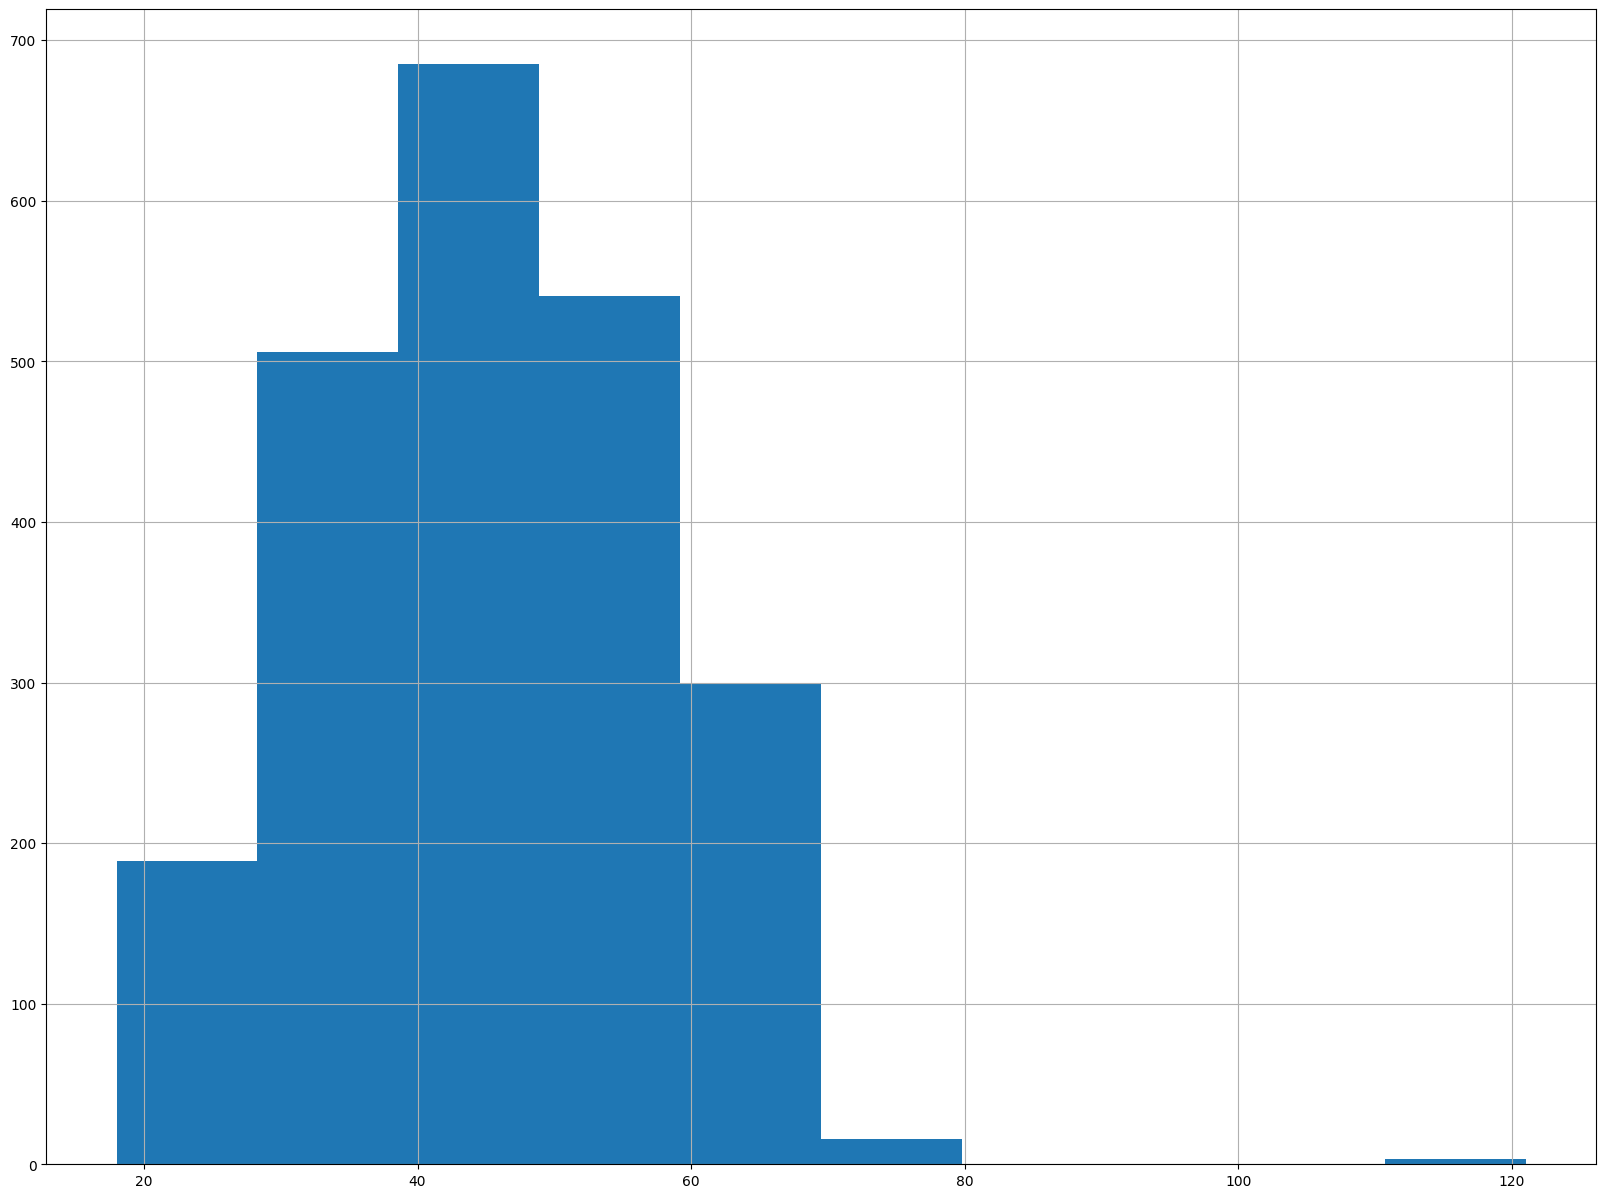

In [12]:
data['Age'].hist(figsize=(20, 15));

In [13]:
#Looking at age historgram above we clipped it values
data['Age'] = data['Age'].clip(lower=18, upper=73)

In [14]:
# I did binning on age as this will be benificial for me later when I'll do clustering to do segmentaions

age_bins = [18, 25, 45, 65, 73]
age_labels = [
    "Young Trend Seekers (18–25)",
    "Value-Oriented Adults (26–45)",
    "Mid-Lifers (46–65)",
    "Mature Elite Shoppers (65+)"
]

data['AgeGroup_Label'] = pd.cut(
    data['Age'],
    bins=age_bins,
    labels=age_labels,
    right=True,
    include_lowest=True
)

# Custom ordinal mapping (preserves natural age order)
age_map = {
    "Young Trend Seekers (18–25)": 0,
    "Value-Oriented Adults (26–45)": 1,
    "Mid-Lifers (46–65)": 2,
    "Mature Elite Shoppers (65+)": 3
}

data['AgeGroup'] = data['AgeGroup_Label'].map(age_map)

print(data['AgeGroup'].isna().sum())
print(data['AgeGroup'].unique())


0
[2, 1, 3, 0]
Categories (4, int64): [0 < 1 < 2 < 3]


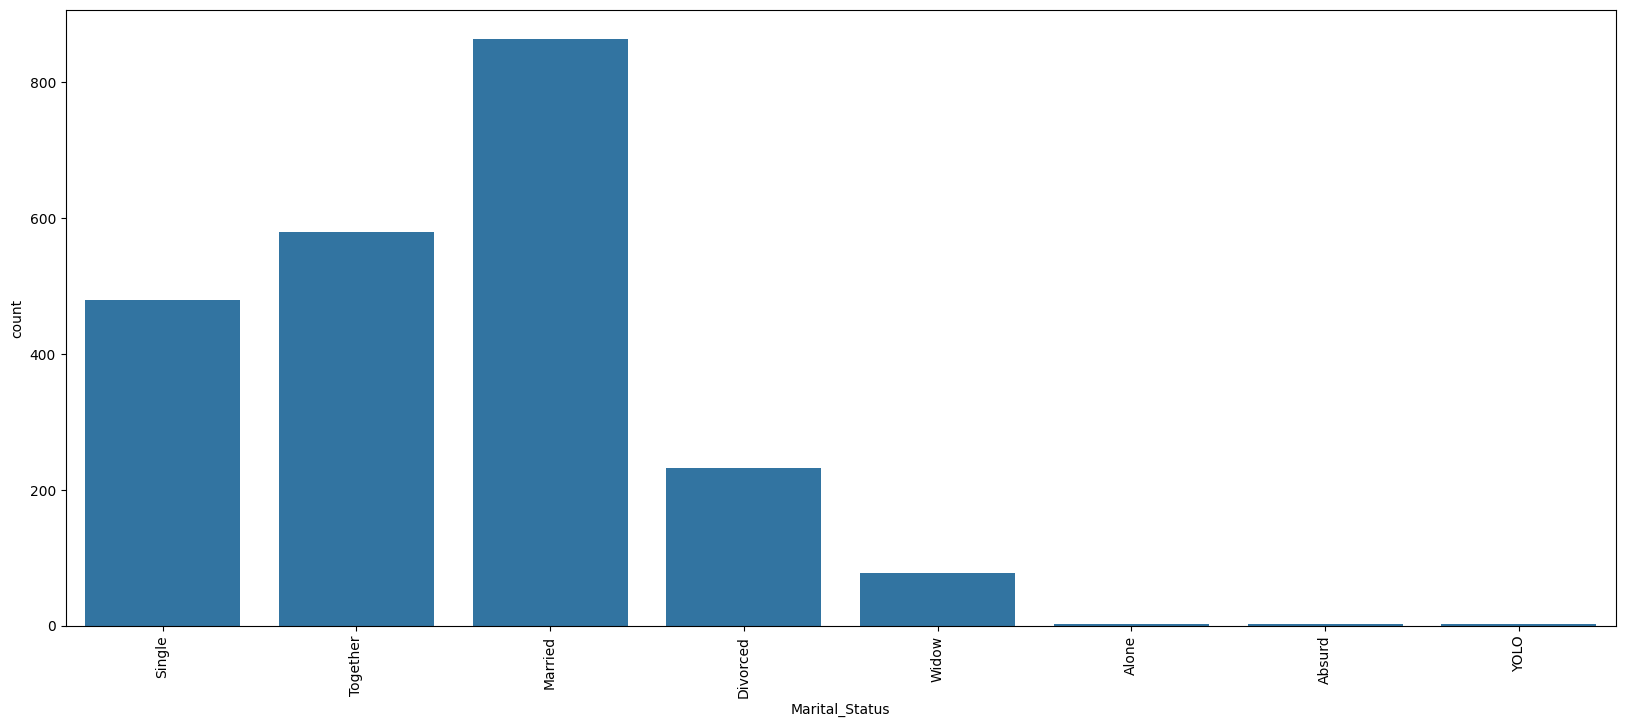

In [15]:
plt.figure(figsize = (20,8))
sns.countplot(x=data['Marital_Status'])
plt.xticks(rotation=90)
plt.show()


In [16]:
#Binned Marital status based on picture given by countplot

data['Marital_Status'] = data['Marital_Status'].replace({
    'Married': 'In Relationship',
    'Together': 'In Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
})

In [17]:
data = data[~data['Marital_Status'].isin(['Alone', 'Absurd','YOLO'])].copy()

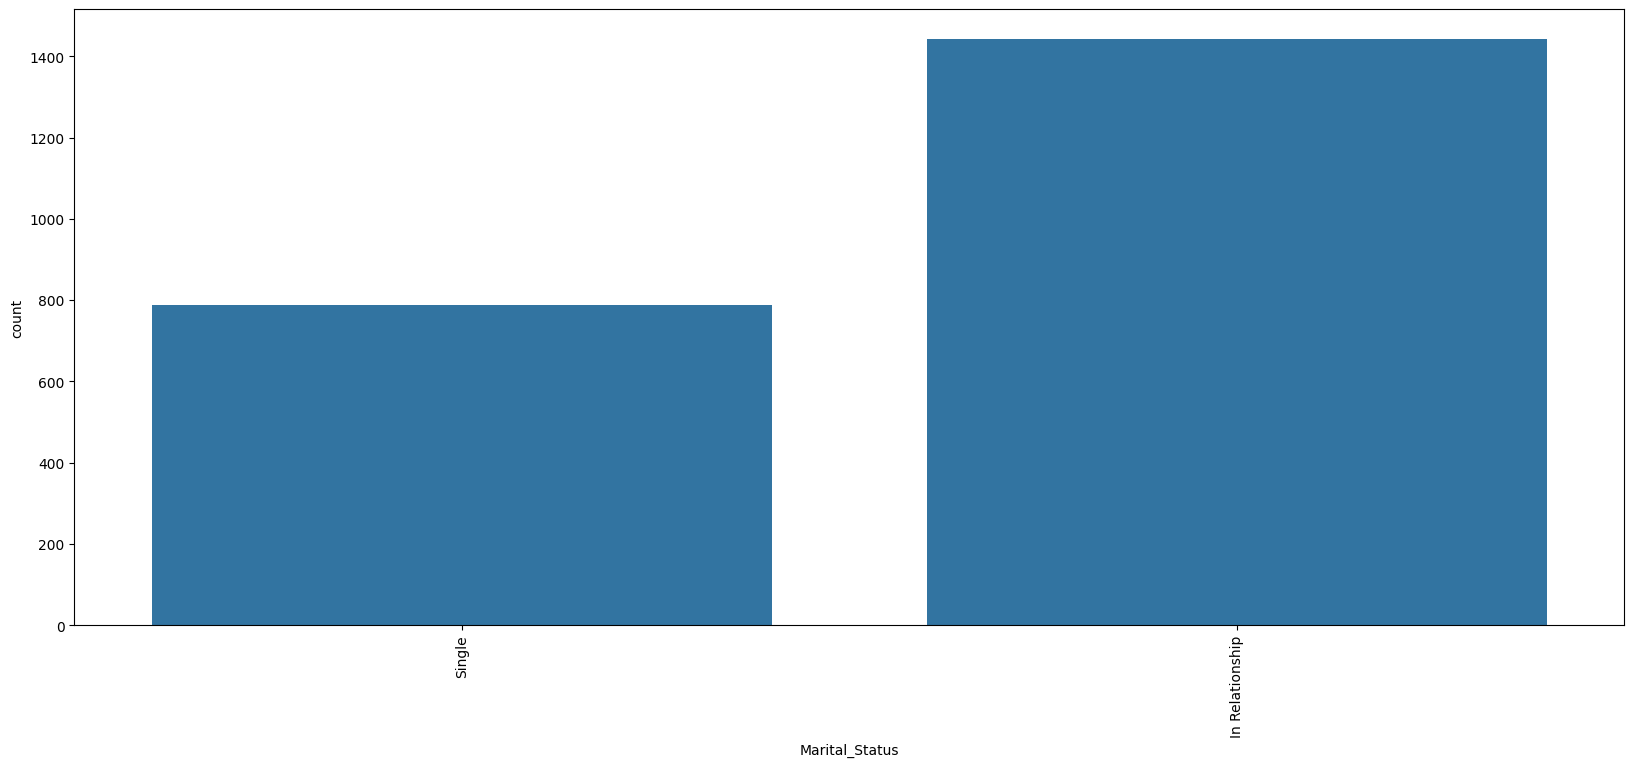

In [18]:
plt.figure(figsize = (20,8))
sns.countplot(x=data['Marital_Status'])
plt.xticks(rotation=90)
plt.show()


In [19]:
# map to binary (1 = In Relationship, 0 = Single) to be able to used in  model
data['Marital_Status'] = data['Marital_Status'].map({
    'In Relationship': 1,
    'Single': 0
})

In [20]:
# Creating combined features for clustering:
# These combined features simplify the data and highlight key patterns for clustering.

data["Purchases"] =  data[["NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]].sum(axis=1)
data["Spending"] = data[["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]].sum(axis=1)
data["Effective_Campaigns"] = data[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].sum(axis=1)

In [21]:
# binning education in 3 categories based on their expenditure and accepted campaigns
data['Education'] = data['Education'].replace(['PhD', 'Master', "Graduation"], "Graduated")
#Label encoding education
le_education = LabelEncoder()
data['Education_Encoded'] = le_education.fit_transform(data['Education'])

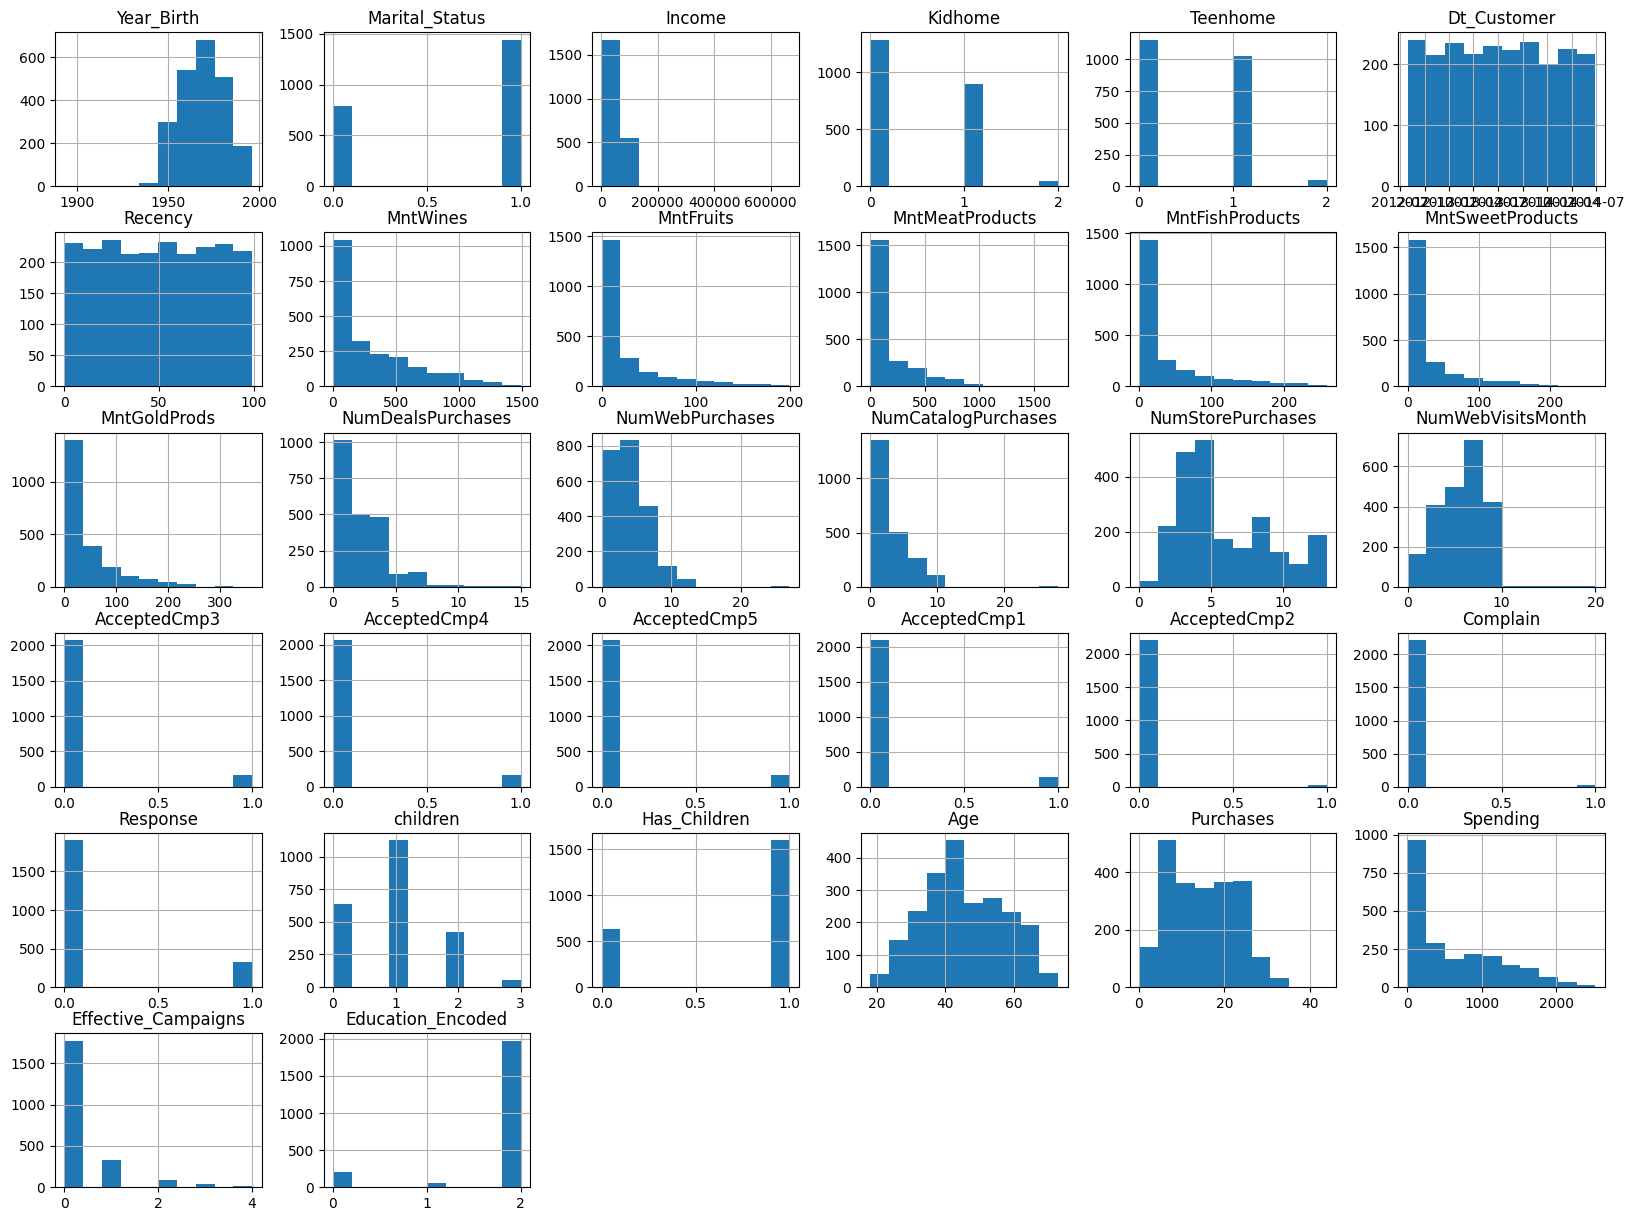

In [22]:
data.hist(figsize=(20, 15));

In [23]:
scaler = StandardScaler()

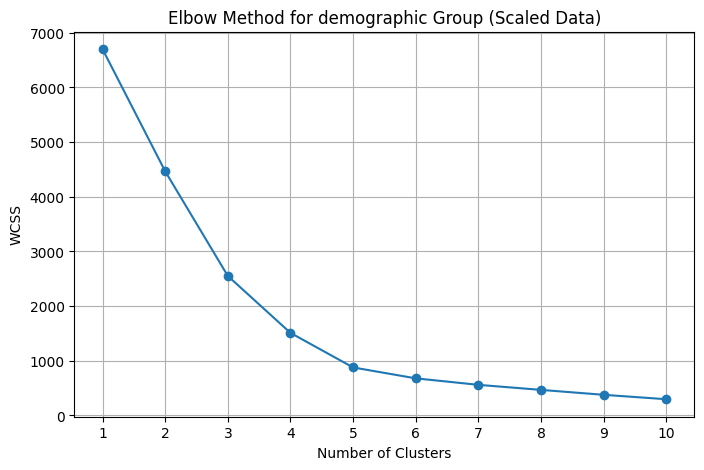

In [ ]:
# # Used the Elbow Method on scaled demographic features to find the optimal number of clustersT

# Demographic_Group = ["AgeGroup", "Education_Encoded", "Marital_Status"]
# Demographic_Group_scaled = scaler.fit_transform(data[Demographic_Group])

# # WCSS vs Clusters
# wcss_demographic = []
# for k in range(1, 11):
#     kmeans_demographic = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
#     kmeans_demographic.fit(Demographic_Group_scaled)  # use scaled data here
#     wcss_demographic.append(kmeans_demographic.inertia_)

# # Elbow Graph
# plt.figure(figsize=(8,5))
# plt.plot(range(1, 11), wcss_demographic, marker='o')
# plt.title("Elbow Method for demographic Group (Scaled Data)")
# plt.xlabel("Number of Clusters")
# plt.ylabel("WCSS")
# plt.xticks(range(1, 11))
# plt.grid(True)
# plt.show()

In [ ]:
# kmeans_demographic = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
# labels_demographic = kmeans_demographic.fit_predict(Demographic_Group_scaled)
# print("Silhouette Score (K-Means):", silhouette_score(Demographic_Group_scaled, labels_demographic))

Silhouette Score (K-Means): 0.8271749371944198


In [ ]:
# # Test different eps values with DBSCAN on scaled demographic data to find meaningful clusters and noise points

# eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0]
# min_samples = 5

# for eps in eps_values:
#     db = DBSCAN(eps=eps, min_samples=min_samples).fit(Demographic_Group_scaled)
#     labels = db.labels_

#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise = list(labels).count(-1)

#     if n_clusters > 1:  # silhouette score needs at least 2 clusters
#         sil = silhouette_score(Demographic_Group_scaled, labels)
#         print(f"eps={eps}: clusters={n_clusters}, noise={n_noise}, silhouette={sil:.3f}")
#     else:
#         print(f"eps={eps}: clusters={n_clusters}, noise={n_noise} (no silhouette)")

eps=0.3: clusters=18, noise=11, silhouette=0.993
eps=0.5: clusters=18, noise=11, silhouette=0.993
eps=0.7: clusters=18, noise=11, silhouette=0.993
eps=1.0: clusters=18, noise=11, silhouette=0.993
eps=1.5: clusters=18, noise=11, silhouette=0.993
eps=2.0: clusters=2, noise=0, silhouette=0.484
eps=3.0: clusters=1, noise=0 (no silhouette)
eps=5.0: clusters=1, noise=0 (no silhouette)


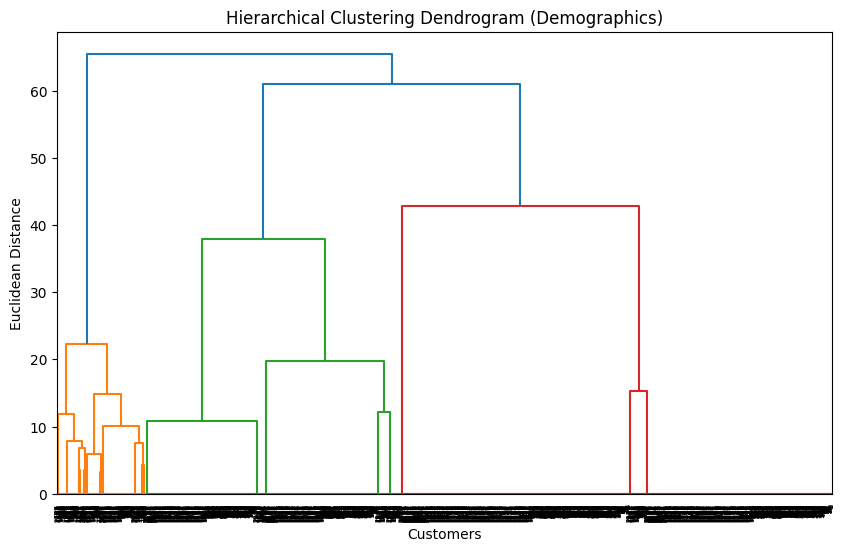

Clusters=2, Silhouette=0.532
Clusters=3, Silhouette=0.566
Clusters=4, Silhouette=0.709
Clusters=5, Silhouette=0.816


In [ ]:
# # Performed hierarchical clustering on demographic data:
# plt.figure(figsize=(10, 6))
# dendrogram = sch.dendrogram(sch.linkage(Demographic_Group_scaled, method='ward'))
# plt.title("Hierarchical Clustering Dendrogram (Demographics)")
# plt.xlabel("Customers")
# plt.ylabel("Euclidean Distance")
# plt.show()

# # --- Try cluster cuts ---
# for k in [2, 3, 4, 5]:
#     hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
#     labels = hc.fit_predict(Demographic_Group_scaled)

#     if len(set(labels)) > 1:  # avoid silhouette error
#         sil = silhouette_score(Demographic_Group_scaled, labels)
#         print(f"Clusters={k}, Silhouette={sil:.3f}")
#     else:
#         print(f"Clusters={k}, Silhouette: Not applicable (only 1 cluster)")


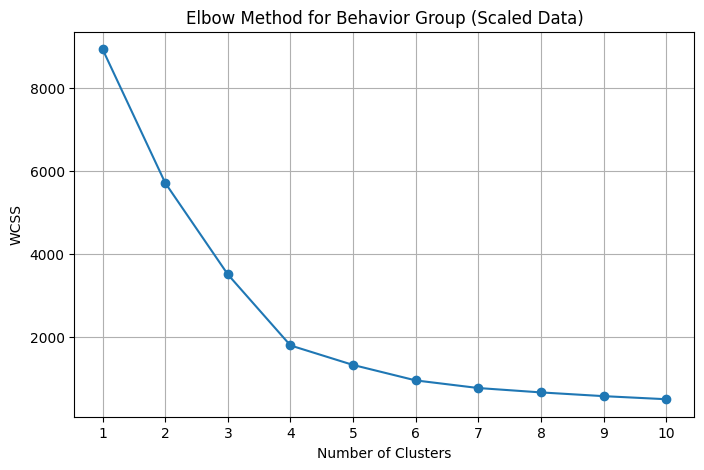

In [28]:
# Used the Elbow Method on scaled Behavior features to find the optimal number of clustersT

Behavior_Group = ["Spending", "Purchases", "Complain", "Response"]

Behavior_Group_scaled = scaler.fit_transform(data[Behavior_Group])

# WCSS vs Clusters
wcss_behavior = []
for k in range(1, 11):
    kmeans_behavior = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    kmeans_behavior.fit(Behavior_Group_scaled)  # use scaled data here
    wcss_behavior.append(kmeans_behavior.inertia_)

# Elbow Graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss_behavior, marker='o')
plt.title("Elbow Method for Behavior Group (Scaled Data)")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [29]:
# Appled K-Means on behavior features to create 5 clusters
kmeans_behavior = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
labels_behavior = kmeans_behavior.fit_predict(Behavior_Group_scaled)
print("Silhouette Score (K-Means):", silhouette_score(Behavior_Group_scaled, labels_behavior))

Silhouette Score (K-Means): 0.6071605830966137


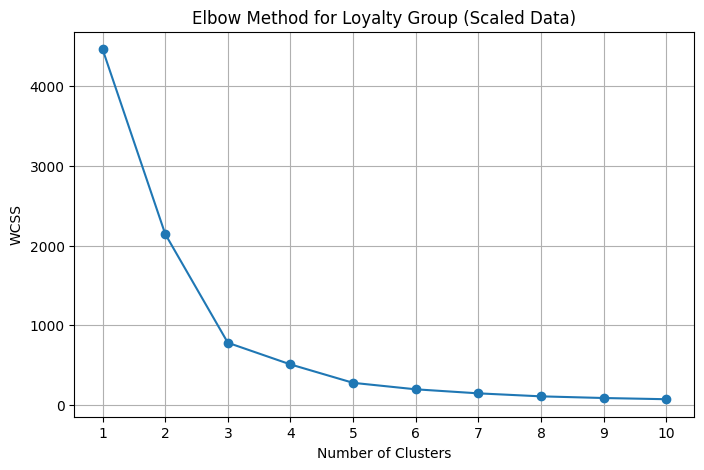

In [30]:
# Define Loyalty group
Loyalty_Group = ["Recency", "Response"]

# Scale data
Loyalty_Group_scaled = scaler.fit_transform(data[Loyalty_Group])

# WCSS vs Clusters|
wcss_loyalty = []

for k in range(1, 11):
    kmeans_loyalty = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    kmeans_loyalty.fit(Loyalty_Group_scaled)  # use scaled data here
    wcss_loyalty.append(kmeans_loyalty.inertia_)

# Elbow Graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss_loyalty, marker='o')
plt.title("Elbow Method for Loyalty Group (Scaled Data)")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [31]:
kmeans_loyalty = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
labels_loyalty = kmeans_loyalty.fit_predict(Loyalty_Group_scaled)
print("Silhouette Score (K-Means):", silhouette_score(Loyalty_Group_scaled, labels_loyalty))

Silhouette Score (K-Means): 0.6051892672785889


In [43]:
# --- Step 1: Attach clusters back to data ---
data['Behavior'] = labels_behavior
data['Loyalty'] = labels_loyalty

# --- Step 2: Create profiling summary (no demographics) ---
cluster_profile = data.groupby(
    ["Behavior", "Loyalty"]
).agg({
    "Spending": "mean",
    "Purchases": "mean",
    "Complain": "mean",         
    "Effective_Campaigns": "mean",
    "Response": "mean",         
    "Recency": "mean",
    "Behavior": "count"
}).rename(columns={"Behavior":"Count"}).reset_index()

cluster_profile = cluster_profile.round(2)

# --- Step 3: Add automatic segment names ---
def assign_segment(row):
    # Behavior interpretation
    if row['Spending'] > 1000:
        behavior = "High Spenders"
    elif row['Spending'] > 400:
        behavior = "Medium Spenders"
    else:
        behavior = "Low Spenders"

    if row['Purchases'] > 30:
        behavior = "Frequent " + behavior
    elif row['Purchases'] < 10:
        behavior = "Occasional " + behavior

    # Loyalty interpretation
    if row['Recency'] < 30 and row['Response'] > 0.3:
        loyalty = "Loyal & Responsive"
    elif row['Recency'] < 30:
        loyalty = "Recent but Unresponsive"
    elif row['Recency'] > 60 and row['Response'] < 0.1:
        loyalty = "Dormant & Lost"
    else:
        loyalty = "At-Risk"

    # Combine all
    return f"{behavior} - {loyalty}"

cluster_profile["Segment_Name"] = cluster_profile.apply(assign_segment, axis=1)

# --- Step 4: Sort by customer count ---
cluster_profile = cluster_profile.sort_values(by="Count", ascending=False)

# --- Step 5: Display ---
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(cluster_profile)

# --- Step 6: (Optional) Export ---
cluster_profile.to_csv("customer_cluster_profiles_named.csv", index=False)


    Behavior  Loyalty  Spending  Purchases  Complain  Effective_Campaigns  \
12         3        3    126.04       8.62       0.0                 0.07   
10         3        0    131.19       8.57       0.0                 0.06   
11         3        1    125.00       8.52       0.0                 0.06   
2          0        3   1101.38      21.38       0.0                 0.37   
1          0        1   1045.93      21.82       0.0                 0.29   
0          0        0   1039.75      21.97       0.0                 0.31   
9          2        4   1446.43      21.27       0.0                 1.20   
14         4        4    217.27      11.63       0.0                 0.41   
8          2        2   1583.14      21.95       0.0                 1.52   
13         4        2    267.82      12.87       0.0                 0.62   
3          1        0    222.00      12.33       1.0                 0.00   
4          1        1    577.50      15.83       1.0                 0.00   

In [45]:
# Merge the segment names from cluster_profile back into the original data
data = data.merge(
    cluster_profile[["Behavior", "Loyalty", "Segment_Name"]],
    on=["Behavior", "Loyalty"],
    how="left"
)

# Preview merged segments
print(data[["Behavior", "Loyalty", "Segment_Name"]].head())


   Behavior  Loyalty                                       Segment_Name
0         2        2                            High Spenders - At-Risk
1         3        1                  Occasional Low Spenders - At-Risk
2         0        0            High Spenders - Recent but Unresponsive
3         3        0  Occasional Low Spenders - Recent but Unresponsive
4         0        3                     High Spenders - Dormant & Lost


In [46]:
from sklearn.ensemble import RandomForestClassifier
import joblib

X = data[["Age", "Education_Encoded", "Marital_Status",
          "Spending", "Purchases", "Complain", "Response",
          "Recency", "Income"]]
y = data["Segment_Name"]

clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

joblib.dump(clf, "segment_classifier.pkl")


['segment_classifier.pkl']

In [ ]:
# Rule-based customer profiling: segment customers into behavioral groups using spending, purchases, campaigns, and recency
# old work
def customer_profiling(df, persist=True):
    """
    Rule-based profiling of customers into behavioral segments.
    """

    cutoffs = {
        "hi_income": df["Income"].quantile(0.65),
        "mid_income": df["Income"].quantile(0.35),
        "hi_spend": df["Spending"].quantile(0.65),
        "mid_spend": df["Spending"].quantile(0.35),
        "recent_active": df["Recency"].quantile(0.5),
        "active_campaigns": df["Effective_Campaigns"].median(),
        "active_buyers": df["Purchases"].quantile(0.4),
        "frequent_buyers": df["Purchases"].quantile(0.7),
    }

    # optionally save reference objects
    if persist:
        joblib.dump(le_education, "edu_encoder.pkl")
        joblib.dump(cutoffs, "profiling_cutoffs.pkl")

    def _segment(row):
        """Assign a customer to one segment based on rules."""

        # high income + high spending OR strong engagement
        if (row["Spending"] > cutoffs["hi_spend"] and
            (row["Purchases"] > cutoffs["frequent_buyers"] or
             row["Effective_Campaigns"] > cutoffs["active_campaigns"] or
             row["Recency"] <= cutoffs["recent_active"])):
            return "Premium Spenders"

        # engaged via campaigns or recent responses
        if ((row["Effective_Campaigns"] > 0 or row["Response"] == 1) and
            row["Recency"] <= cutoffs["recent_active"]):
            return "Value Seekers"

        # buy frequently, fairly recent, but not heavy spenders
        if (row["Recency"] <= cutoffs["recent_active"] and
            row["Purchases"] >= cutoffs["active_buyers"] and
            row["Spending"] < cutoffs["hi_spend"]):
            return "Budget-Conscious"

        # long inactive, low purchases, never engaged
        if (row["Recency"] > df["Recency"].quantile(0.8) and
            row["Purchases"] < cutoffs["active_buyers"] and
            row["Effective_Campaigns"] == 0):
            return "Dormant/Unengaged"

        # fallback: moderate spenders vs others
        return "Budget-Conscious" if row["Spending"] >= cutoffs["mid_spend"] else "Value Seekers"

    return _segment, cutoffs


segmenter, rules = customer_profiling(data)
data["Rule_Based_Segment"] = data.apply(segmenter, axis=1)

print(" RULE-BASED SEGMENT DISTRIBUTION ".center(50, "="))
for seg, cnt in data["Rule_Based_Segment"].value_counts().items():
    pct = (cnt / len(data)) * 100
    print(f"{seg:<20}: {cnt} customers ({pct:.1f}%)")

print(f"High Income: ${rules['hi_income']:,.0f} (65th percentile)")
print(f"Mid Income: ${rules['mid_income']:,.0f} (35th percentile)")
print(f"High Spend: ${rules['hi_spend']:,.0f} (65th percentile)")
print(f"Active Recency: {rules['recent_active']:.0f} days (median)")


======== RULE-BASED SEGMENT DISTRIBUTION =========
Value Seekers       : 709 customers (31.8%)
Premium Spenders    : 684 customers (30.6%)
Budget-Conscious    : 681 customers (30.5%)
Dormant/Unengaged   : 159 customers (7.1%)
High Income: $61,865 (65th percentile)
Mid Income: $41,647 (35th percentile)
High Spend: $791 (65th percentile)
Active Recency: 50 days (median)


In [ ]:
#Profiling Summary
# old work
data["AgeGroup"] = data["AgeGroup"].astype(int)

profile_summary = data.groupby("Rule_Based_Segment").agg({
    "Income": "mean",
    "Spending": "mean",
    "Purchases": "mean",
    "Recency": "mean",
    "Effective_Campaigns": "mean",
    "Response": "mean",
    "AgeGroup": "mean"
})

print("\n=== CLUSTER PROFILE SUMMARY ===")
print(profile_summary)


=== CLUSTER PROFILE SUMMARY ===
                          Income     Spending  Purchases    Recency  \
Rule_Based_Segment                                                    
Budget-Conscious    54817.118209   524.743025  16.340675  53.935389   
Dormant/Unengaged   36696.795597    67.459119   6.716981  88.842767   
Premium Spenders    72366.941520  1338.682749  22.570175  46.673977   
Value Seekers       33816.455571    97.672779   7.813822  38.111425   

                    Effective_Campaigns  Response  AgeGroup  
Rule_Based_Segment                                           
Budget-Conscious               0.074890  0.042584  1.540382  
Dormant/Unengaged              0.000000  0.000000  1.408805  
Premium Spenders               0.719298  0.266082  1.520468  
Value Seekers                  0.170663  0.169252  1.287729  


In [34]:
# features for supervised model
X = data[["Income", "Spending", "Purchases", "Recency", "Effective_Campaigns", "Response"]]
y = data["Rule_Based_Segment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)



In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 1.0
F1 Score (macro): 1.0

Classification Report:
                    precision    recall  f1-score   support

 Budget-Conscious       1.00      1.00      1.00       136
Dormant/Unengaged       1.00      1.00      1.00        32
 Premium Spenders       1.00      1.00      1.00       137
    Value Seekers       1.00      1.00      1.00       142

         accuracy                           1.00       447
        macro avg       1.00      1.00      1.00       447
     weighted avg       1.00      1.00      1.00       447



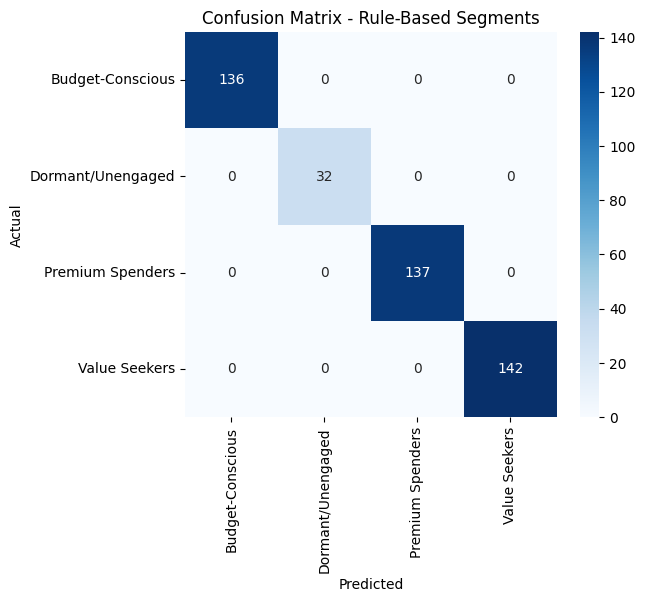


Predicted Segments for New Customers:
   Income  Spending  Purchases  Recency  Effective_Campaigns  Response  \
0   40000       500          5       20                    1         1   
1  120000      3500         25      200                    3         0   
2   75000      1500         12       60                    0         0   

  Predicted_Segment  
0     Value Seekers  
1  Premium Spenders  
2  Budget-Conscious  


In [36]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Rule-Based Segments")
plt.show()

new_customers = pd.DataFrame({
    "Income": [40000, 120000, 75000],
    "Spending": [500, 3500, 1500],
    "Purchases": [5, 25, 12],
    "Recency": [20, 200, 60],
    "Effective_Campaigns": [1, 3, 0],
    "Response": [1, 0, 0]
})

new_preds = rf.predict(new_customers)
print("\nPredicted Segments for New Customers:")
print(pd.DataFrame(new_customers).assign(Predicted_Segment=new_preds))

In [37]:
import joblib

# Save RandomForest model
joblib.dump(rf, "segmentation_model2.pkl")

# Save LabelEncoder
joblib.dump(le_education, "edu_encoder.pkl")

# Save profiling cutoffs (for rule-based segmentation if needed)
joblib.dump(rules, "profiling_cutoffs.pkl")


['profiling_cutoffs.pkl']